# IE343 -- Statistical Machine Learning and Its Applications
## Lab 10: Introduction to Deep Learning
- [1. Feed-forward Neural Network](#1.-Feed-forward-Neural-Network)
    - [1.1. Backpropagation from scratch](#1.1.-Backpropagation-from-scratch)
    - [1.2. Backpropagation using PyTorch](#1.2.-Backpropagation-using-PyTorch)
- [2. Convolutional Neural Network](#2.-Convolutional-Neural-Network)
- [3. Recurrent Neural Network](#3.-Recurrent-Neural-Network)

- Install PyTorch
    - https://pytorch.org/get-started/locally/
- Before you watch this video, I suggest you try the following tutorials on basics of PyTorch.
    - https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/01-basics/pytorch_basics/main.py
    - https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/01-basics/linear_regression/main.py
    - https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/01-basics/logistic_regression/main.py

## 1. Feed-forward Neural Network

<div>
<img src="figures/ffn.png" width="800"/>
</div>

### 1.1. Backpropagation from scratch
Reference: https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/forwardpropagation_backpropagation_gradientdescent/

In [1]:
from sklearn import datasets
from sklearn import preprocessing
import numpy as np
np.random.seed(0)
from sklearn.metrics import accuracy_score, roc_auc_score

In [2]:
iris = datasets.load_iris()
X = np.array(preprocessing.normalize(iris.data[:, :2]))
y = np.array(iris.target.reshape(-1, 1))

In [3]:
# We only take 2 classes to make a binary classification problem
X = X[:y[y < 2].size]
y = y[:y[y < 2].size]

In [4]:
# Shuffle dataset
idxs = np.random.permutation(X.shape[0])

X = X[idxs]
y = y[idxs]

X_train = X[:80]
X_test = X[80:]

y_train = y[:80]
y_test = y[80:]

In [5]:
class FNN_scratch():
    def __init__(self):       
        # Dimensions for input, hidden and output
        self.input_dim = 2
        self.hidden_dim = 32
        self.output_dim = 1
        
        # Learning rate definition
        self.learning_rate = 0.001
        
        # Our parameters (weights)
        # w1: 2 x 32
        self.w1 = np.random.randn(self.input_dim, self.hidden_dim)
        
        # w2: 32 x 1
        self.w2 = np.random.randn(self.hidden_dim, self.output_dim)
    
    def sigmoid(self, s):
        return 1 / (1 + np.exp(-s))
    
    def sigmoid_first_order_derivative(self, s):
        return s * (1 - s)
    
    # Forward propagation
    def forward(self, X):
        # First linear layer
        self.y1 = np.matmul(X, self.w1) 
        
        # First non-linearity
        self.y2 = self.sigmoid(self.y1)
        
        # Second linear layer
        self.y3 = np.matmul(self.y2, self.w2)
        
        # Second non-linearity (output)
        y4 = self.sigmoid(self.y3)
        return y4
        
    # Backward propagation
    def backward(self, X, t, y4):
        # Derivative of binary cross entropy cost w.r.t. final output y4
        self.dL_dy4 = -t/y4 + (1-t)/(1-y4)
        
        '''
        Gradients for w2: partial derivative of cost w.r.t. w2
        dL/dw2
        '''
        self.dy4_dy3 = self.sigmoid_first_order_derivative(y4)
        self.dy3_dw2 = self.y2
        
        # Y4 delta: dL_dy4 dy4_dy3
        self.y4_delta = self.dL_dy4 * self.dy4_dy3
        
        # This is our gradients for w1: dL_dy4 dy4_dy3 dy3_dw2
        self.dL_dw2 = np.matmul(np.transpose(self.dy3_dw2), self.y4_delta)
        
        '''
        Gradients for w1: partial derivative of cost w.r.t w1
        dL/dw1
        '''
        self.dy3_dy2 = self.w2
        self.dy2_dy1 = self.sigmoid_first_order_derivative(self.y2)
        
        # Y2 delta: (dL_dy4 dy4_dy3) dy3_dy2 dy2_dy1
        self.y2_delta = np.matmul(self.y4_delta, np.transpose(self.dy3_dy2)) * self.dy2_dy1
        
        # Gradients for w1: (dL_dy4 dy4_dy3) dy3_dy2 dy2_dy1 dy1_dw1
        self.dL_dw1 = np.matmul(np.transpose(X), self.y2_delta)
        
        # Gradient descent on the weights from our 2 linear layers
        self.w1 -= self.learning_rate * self.dL_dw1
        self.w2 -= self.learning_rate * self.dL_dw2

    def train(self, X, t):
        # Forward propagation
        y4 = self.forward(X)
        
        # Backward propagation and gradient descent
        self.backward(X, t, y4)

In [6]:
# Instantiate our model class and assign it to our model object
model = FNN_scratch()

# Loss list for plotting of loss behaviour
loss_lst = []

# Number of times we want our FNN to look at all 100 samples we have, 100 implies looking through 100x
num_epochs = 201

# Let's train our model with 100 epochs
for epoch in range(num_epochs):
    # Get our predictions
    y_hat = model.forward(X_train)
    
    # Cross entropy loss, remember this can never be negative by nature of the equation
    # But it does not mean the loss can't be negative for other loss functions
    cross_entropy_loss = -(y_train * np.log(y_hat) + (1 - y_train) * np.log(1 - y_hat))
    # We have to take cross entropy loss over all our samples, 100 in this 2-class iris dataset
    mean_cross_entropy_loss = np.mean(cross_entropy_loss)
    
    # Print our mean cross entropy loss
    if epoch % 20 == 0:
        print('Epoch {} | Loss: {}'.format(epoch, mean_cross_entropy_loss))
    loss_lst.append(mean_cross_entropy_loss)
    
    # (1) Forward propagation: to get our predictions to pass to our cross entropy loss function
    # (2) Back propagation: get our partial derivatives w.r.t. parameters (gradients)
    # (3) Gradient Descent: update our weights with our gradients
    model.train(X_train, y_train)

# test accuracy    
y_hat = model.forward(X_test)    
roc_auc_score(y_test, y_hat)

Epoch 0 | Loss: 2.652711898568197
Epoch 20 | Loss: 0.7640960477582258
Epoch 40 | Loss: 0.7531119085694555
Epoch 60 | Loss: 0.7434870879560883
Epoch 80 | Loss: 0.7341176912315992
Epoch 100 | Loss: 0.7249847721205718
Epoch 120 | Loss: 0.7160708754743663
Epoch 140 | Loss: 0.7073598952523377
Epoch 160 | Loss: 0.6988369754034756
Epoch 180 | Loss: 0.6904884196223567
Epoch 200 | Loss: 0.6823016090798898


1.0

### 1.2. Backpropagation using PyTorch

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# To fix the random seed
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [8]:
iris = datasets.load_iris()
X = torch.tensor(preprocessing.normalize(iris.data[:, :2]), dtype=torch.float)
y = torch.tensor(iris.target.reshape(-1, 1), dtype=torch.float)

# We only take 2 classes to make a binary classification problem
X = X[:y[y < 2].size()[0]]
y = y[:y[y < 2].size()[0]]

In [9]:
# Shuffle dataset
idxs = np.random.permutation(X.shape[0])

X = X[idxs]
y = y[idxs]

X_train = X[:80]
X_test = X[80:]

y_train = y[:80]
y_test = y[80:]

In [10]:
class FNN_pytorch(nn.Module):
    def __init__(self, ):
        super().__init__()
        
        # Dimensions for input, hidden and output
        self.input_dim = 2
        self.hidden_dim = 32
        self.output_dim = 1
        
        # First hidden layer
        self.fc1 = nn.Linear(self.input_dim, self.hidden_dim)
        
        # Second hidden layer
        self.fc2 = nn.Linear(self.hidden_dim, self.output_dim)
        
    def forward(self, X):
        # y1 = W1 x X
        y1 = self.fc1(X)
        
        # y2 = sigma(y1)
        y2 = torch.sigmoid(y1)
        
        # y3 = W2 x y2
        y3 = self.fc2(y2)
        
        # y4 = sigma(y3)
        y4 = torch.sigmoid(y3)
        
        return y4

In [11]:
# Instantiate our model class and assign it to our model object
model = FNN_pytorch()

# Loss list for plotting of loss behaviour
loss_lst = []

# Number of times we want our FNN to look at all 100 samples we have, 100 implies looking through 100x
num_epochs = 201

# Define loss (binary cross entropy)
criterion = nn.BCELoss()

# Define optimizer and set learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Let's train our model with 100 epochs
for epoch in range(num_epochs):
    # zeroes the gradient buffers of all parameters
    model.zero_grad()
    
    # (1) Forward propagation: to get our predictions to pass to our cross entropy loss function
    # Get our predictions
    y_hat = model(X_train)
    
    # Cross entropy loss
    loss = criterion(y_hat, y_train)
    
    # (2) Back propagation: get our partial derivatives w.r.t. parameters (gradients)
    # compute gradients
    loss.backward()
    
    # (3) Gradient Descent: update our weights with our gradients
    # update parameters
    optimizer.step()
    
    # Print our mean cross entropy loss
    if epoch % 20 == 0:
        print('Epoch {} | Loss: {}'.format(epoch, loss.item()))
    loss_lst.append(loss.item())

# test accuracy
y_hat = model(X_test)    
roc_auc_score(y_test, y_hat.detach().numpy())

Epoch 0 | Loss: 0.7028536200523376
Epoch 20 | Loss: 0.6915583610534668
Epoch 40 | Loss: 0.6904309988021851
Epoch 60 | Loss: 0.6890848875045776
Epoch 80 | Loss: 0.6876074075698853
Epoch 100 | Loss: 0.685966432094574
Epoch 120 | Loss: 0.684127688407898
Epoch 140 | Loss: 0.6820585131645203
Epoch 160 | Loss: 0.6797219514846802
Epoch 180 | Loss: 0.6770758628845215
Epoch 200 | Loss: 0.6740745902061462


1.0

## 2. Convolutional Neural Network
Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

<div>
<img src="figures/cnn.png" width="800"/>
</div>

In [12]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

In [13]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


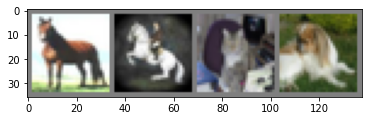

horse horse   cat   dog


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [16]:
cnn = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

In [17]:
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # (1) Forward propagation: to get our predictions to pass to our cross entropy loss function
        # Get our predictions
        outputs = cnn(inputs)
        
        # Cross entropy loss
        loss = criterion(outputs, labels)
        
        # (2) Back propagation: get our partial derivatives w.r.t. parameters (gradients)
        # compute gradients
        loss.backward()
        
        # (3) Gradient Descent: update our weights with our gradients
        # update parameters
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.185
[1,  4000] loss: 1.862
[1,  6000] loss: 1.682
[1,  8000] loss: 1.602
[1, 10000] loss: 1.529
[1, 12000] loss: 1.480
[2,  2000] loss: 1.412
[2,  4000] loss: 1.396
[2,  6000] loss: 1.335
[2,  8000] loss: 1.339
[2, 10000] loss: 1.296
[2, 12000] loss: 1.299
Finished Training


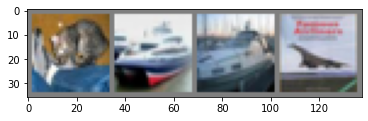

GroundTruth:    cat  ship  ship plane


In [18]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [19]:
outputs = cnn(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship   car  ship


In [20]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network 
        outputs = cnn(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


In [21]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data    
        outputs = cnn(images)    
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))

Accuracy for class plane is: 58.9 %
Accuracy for class car   is: 55.2 %
Accuracy for class bird  is: 48.0 %
Accuracy for class cat   is: 23.9 %
Accuracy for class deer  is: 44.1 %
Accuracy for class dog   is: 54.5 %
Accuracy for class frog  is: 71.3 %
Accuracy for class horse is: 65.2 %
Accuracy for class ship  is: 66.8 %
Accuracy for class truck is: 74.5 %


## 3. Recurrent Neural Network
Reference: https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/recurrent_neural_network/main.py

<div>
<img src="figures/rnn.png" width="800"/>
</div>

In [22]:
# Hyper-parameters
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 100
num_epochs = 2
learning_rate = 0.001

In [24]:
from torchvision.datasets import MNIST

transform = transforms.Compose([transforms.ToTensor()])

# MNIST dataset
train_dataset = MNIST(root = './data/', train=True, transform=transform)
test_dataset = MNIST(root = './data/', train=False, transform=transform)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

In [25]:
# Recurrent neural network (many-to-one)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        # Forward propagate RNN
        out, hn = self.rnn(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size), hn: tensor of shape (num_layers * num_directions, batch_size, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])  # out = self.fc(hn[-1,:,:]). <-- This gives us the equivalent output.
        return out

In [ ]:
rnn = RNN(input_size, hidden_size, num_layers, num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, sequence_length, input_size)
        labels = labels
        
        # Forward pass
        outputs = rnn(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
rnn.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size)
        labels = labels
        outputs = rnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total)) 

# Save the model checkpoint
torch.save(rnn.state_dict(), 'rnn.ckpt')

Epoch [1/2], Step [100/600], Loss: 0.9483
Epoch [1/2], Step [200/600], Loss: 0.5975
Epoch [1/2], Step [300/600], Loss: 0.7230
Epoch [1/2], Step [400/600], Loss: 0.6153
Epoch [1/2], Step [500/600], Loss: 0.4330
Epoch [1/2], Step [600/600], Loss: 0.3194
Epoch [2/2], Step [100/600], Loss: 0.4147
Epoch [2/2], Step [200/600], Loss: 0.2786
Epoch [2/2], Step [300/600], Loss: 0.0803
